In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from db import helper as db_helper
from db.models import SpotRate
import pandas as pd

In [3]:
session = db_helper.start_session()

df = pd.read_sql_table('spot_rates', session.bind)

2019-01-21 21:02:09,855 INFO sqlalchemy.engine.base.Engine select version()
2019-01-21 21:02:09,858 INFO sqlalchemy.engine.base.Engine {}
2019-01-21 21:02:09,879 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-01-21 21:02:09,880 INFO sqlalchemy.engine.base.Engine {}
2019-01-21 21:02:09,889 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-21 21:02:09,890 INFO sqlalchemy.engine.base.Engine {}
2019-01-21 21:02:09,894 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-21 21:02:09,895 INFO sqlalchemy.engine.base.Engine {}
2019-01-21 21:02:09,896 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-01-21 21:02:09,897 INFO sqlalchemy.engine.base.Engine {}
2019-01-21 21:02:09,902 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind = 'r'
2019-01-21 21:

2019-01-21 21:02:10,027 INFO sqlalchemy.engine.base.Engine {}


In [4]:
# Quick snapshot of the data
df.describe()

# lack of significant data in the 52wk columns
df.drop(columns=['id', 'url', 'target_52wk_high', 'target_52wk_low', 'created_at', 'updated_at'], inplace=True)

In [6]:
# create Date
import datetime
df['date'] = df.apply(lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df = df[['date','day','month','week','year','base_currency','target_currency','base_value','target_spot_rate']]
# df = df[['date','day','month','week','year','base_currency','target_currency','target_currency_symbol','base_value','target_spot_rate']]

# df.drop(columns=['day', 'month', 'year'], inplace=True)

df.head()

,date,day,month,week,year,base_currency,target_currency,base_value,target_spot_rate
0,2007-05-31,31,5,22,2007,USD,Australian Dollar,1.0,1.2082
1,2007-05-31,31,5,22,2007,USD,Canadian Dollar,1.0,1.0691
2,2007-05-31,31,5,22,2007,USD,Chinese Yuan,1.0,7.6450
3,2007-05-31,31,5,22,2007,USD,Cyprus Pound,1.0,0.4336
4,2007-05-31,31,5,22,2007,USD,Czech Koruna,1.0,21.0323


In [7]:
# Convert target_curency into Iso Symbol
currency_dict = {'Japanese Yen': 'JPY','Malaysian ringgit': 'MYR','New Zealand Dollar': 'NZD','Norwegian Krone': 'NOK','Polish Zloty': 'PLN','Russian Ruble': 'RUB','Saudi Riyal': 'SAR','Singapore Dollar': 'SGD','South African Rand': 'ZAR','South Korean Won': 'KRW','Swedish Krona': 'SEK','Swiss Franc': 'CHF','Taiwan Dollar': 'TWD','Thai Baht': 'THB','Turkish Lira': 'TRY','US Dollar': 'USD','Australian Dollar': 'AUD','Canadian Dollar': 'CAD','Chinese Yuan': 'Yuan','Cyprus Pound': 'CYP','Czech Koruna': 'CZK','Danish Krone': 'DKK','Estonian Kroon': 'EEK','Euro': 'EUR','Hong Kong Dollar': 'HKD','Hungarian Forint': 'HUF','Indian Rupee': 'INR','Israeli Shekel': 'ILS','Latvian Lats': 'LVL','Lithuanian Litas': 'LTL','Maltese Lira': 'MTL','Slovak Koruna': 'SKK','Slovenian Tolar': 'SIT','Sterling': 'GBP','Swedish Krona ': 'SEK','Brazilian Real': 'BRL','Austrian Schilling': 'ATS','Belgian Franc': 'BEF','Deutschemark': 'DEM','Finnish Markka': 'FIM','French Franc': 'FRF','Greek Drachma': 'GRD','Irish Punt': 'IEP','Italian Lire': 'ITL','Netherlands Guilder': 'NLG','Portuguese Escudo': 'PTE','Spanish Peseta': 'ESP'}

df['target_currency'].replace('Latvian Lats\r\nCurrency joined the Euro on 01/01/2014', 'Latvian Lats', inplace=True)
df['target_currency_symbol'] = df['target_currency'].apply(lambda x: currency_dict[x])
df[df['target_currency_symbol'].isnull()]
df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,date,day,month,week,year,base_currency,target_currency,base_value,target_spot_rate,target_currency_symbol
0,2007-05-31,31,5,22,2007,USD,Australian Dollar,1.0,1.2082,AUD
1,2007-05-31,31,5,22,2007,USD,Canadian Dollar,1.0,1.0691,CAD
2,2007-05-31,31,5,22,2007,USD,Chinese Yuan,1.0,7.6450,Yuan
3,2007-05-31,31,5,22,2007,USD,Cyprus Pound,1.0,0.4336,CYP
4,2007-05-31,31,5,22,2007,USD,Czech Koruna,1.0,21.0323,CZK


In [8]:
# Split DF by currency
gbp_df = df[(df['base_currency']=='GBP')]
usd_df = df[(df['base_currency']=='USD')]
eur_df = df[(df['base_currency']=='EUR')]

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')

gbp_usd = gbp_df[gbp_df['target_currency_symbol']=='USD']
gbp_eur = gbp_df[gbp_df['target_currency_symbol']=='EUR']
gbp_jpy = gbp_df[gbp_df['target_currency_symbol']=='JPY']

ax = sns.lineplot(x='date', y='target_spot_rate', data=gbp_usd, label='1 GBP = USD')
ax = sns.lineplot(x='date', y='target_spot_rate', data=gbp_eur, label='1 GBP = EUR')
# ax = sns.lineplot(x='date', y='target_spot_rate', data=gbp_jpy, label='1 GBP = JPY')

plt.show()

<Figure size 1600x800 with 1 Axes>

In [379]:
# %%timeit
# def change_from_n_days_ago(df, target_currency_symbol, current_date, current_rate, n):

#     df = df[df['target_currency_symbol']==target_currency_symbol]

#     try:
#         previous_period_rate = df[df.date < current_date - pd.to_timedelta(n, 'D')].sort_values('date', ascending=False).iloc[0]['target_spot_rate']
#         change = current_rate - previous_period_rate
#     except:
#         change = None

#     return change

# temp = gbp_df.head(10)
# temp['test'] = temp.apply(lambda x: change_from_n_days_ago(temp, x['target_currency_symbol'], x['date'], x['target_spot_rate'], 1), axis=1)
# temp.sort_values(['target_currency_symbol', 'date'], ascending=False)

In [10]:
gbp_df.shape

(122968, 10)

In [11]:
gbp_pivot_df = gbp_df.pivot(index='date', columns='target_currency_symbol', values='target_spot_rate')

In [12]:
gbp_pivot_d_change = gbp_pivot_df/gbp_pivot_df.shift(1, freq=pd.to_timedelta(1, 'D')) - 1
gbp_pivot_d_change = gbp_pivot_d_change.unstack().reset_index().rename({0: '1d_return'}, axis=1)

gbp_pivot_w_change = gbp_pivot_df/gbp_pivot_df.shift(7, freq=pd.to_timedelta(1, 'D')) - 1
gbp_pivot_w_change = gbp_pivot_w_change.unstack().reset_index().rename({0: '1w_return'}, axis=1)

gbp_pivot_m_change = gbp_pivot_df/gbp_pivot_df.shift(30, freq=pd.to_timedelta(1, 'D')) - 1
gbp_pivot_m_change = gbp_pivot_m_change.unstack().reset_index().rename({0: '1m_return'}, axis=1)

gbp_pivot_y_change = gbp_pivot_df/gbp_pivot_df.shift(365, freq=pd.to_timedelta(1, 'D')) - 1
gbp_pivot_y_change = gbp_pivot_y_change.unstack().reset_index().rename({0: '1y_return'}, axis=1)

In [13]:
gbp_df = gbp_df.merge(gbp_pivot_d_change, how='left', on=['date', 'target_currency_symbol'])
gbp_df = gbp_df.merge(gbp_pivot_w_change, how='left', on=['date', 'target_currency_symbol'])
gbp_df = gbp_df.merge(gbp_pivot_m_change, how='left', on=['date', 'target_currency_symbol'])
gbp_df = gbp_df.merge(gbp_pivot_y_change, how='left', on=['date', 'target_currency_symbol'])
gbp_df = gbp_df[~gbp_df['base_currency'].isnull()]
gbp_df.head()

,date,day,month,week,year,base_currency,target_currency,base_value,target_spot_rate,target_currency_symbol,1d_return,1w_return,1m_return,1y_return
0,2018-10-01,1,10,40,2018,GBP,Australian Dollar,1.0,1.8068,AUD,NaN,-0.000940,NaN,NaN
1,2018-10-01,1,10,40,2018,GBP,Canadian Dollar,1.0,1.6729,CAD,NaN,-0.015420,NaN,NaN
2,2018-10-01,1,10,40,2018,GBP,Chinese Yuan,1.0,8.9579,Yuan,NaN,-0.005562,NaN,NaN
3,2018-10-01,1,10,40,2018,GBP,Czech Koruna,1.0,29.0475,CZK,NaN,0.017208,NaN,NaN
4,2018-10-01,1,10,40,2018,GBP,Danish Krone,1.0,8.3960,DKK,NaN,0.009875,NaN,NaN


In [14]:
week_vol = gbp_df.groupby(['week', 'month', 'year', 'target_currency_symbol'])['target_spot_rate'].std()
week_vol = week_vol.reset_index().rename({'target_spot_rate': '1w_vol'}, axis=1)

month_vol = gbp_df.groupby(['month', 'year', 'target_currency_symbol'])['target_spot_rate'].std()
month_vol = month_vol.reset_index().rename({'target_spot_rate': '1m_vol'}, axis=1)

year_vol = gbp_df.groupby(['year', 'target_currency_symbol'])['target_spot_rate'].std()
year_vol = year_vol.reset_index().rename({'target_spot_rate': '1y_vol'}, axis=1)

week_vol.head()
month_vol.head()
year_vol.head()

,year,target_currency_symbol,1y_vol
0,2000,ATS,0.504681
1,2000,AUD,0.079927
2,2000,BEF,1.479057
3,2000,CAD,0.069270
4,2000,CHF,0.063835


In [15]:
gbp_df = gbp_df.merge(week_vol, how='left', on=['week', 'month', 'year', 'target_currency_symbol'])
gbp_df = gbp_df.merge(month_vol, how='left', on=['month', 'year', 'target_currency_symbol'])
gbp_df = gbp_df.merge(year_vol, how='left', on=['year', 'target_currency_symbol'])

gbp_df.head()

,date,day,month,week,year,base_currency,target_currency,base_value,target_spot_rate,target_currency_symbol,1d_return,1w_return,1m_return,1y_return,1w_vol,1m_vol,1y_vol
0,2018-10-01,1,10,40,2018,GBP,Australian Dollar,1.0,1.8068,AUD,NaN,-0.000940,NaN,NaN,0.020635,0.020166,0.032744
1,2018-10-01,1,10,40,2018,GBP,Canadian Dollar,1.0,1.6729,CAD,NaN,-0.015420,NaN,NaN,0.010306,0.017219,0.040853
2,2018-10-01,1,10,40,2018,GBP,Chinese Yuan,1.0,8.9579,Yuan,NaN,-0.005562,NaN,NaN,0.024415,0.084348,0.147415
3,2018-10-01,1,10,40,2018,GBP,Czech Koruna,1.0,29.0475,CZK,NaN,0.017208,NaN,NaN,0.125021,0.182459,0.336169
4,2018-10-01,1,10,40,2018,GBP,Danish Krone,1.0,8.3960,DKK,NaN,0.009875,NaN,NaN,0.037457,0.051445,0.081594


In [19]:
import numpy as np
temp = gbp_df[gbp_df['target_currency_symbol']=='USD'].sort_values('date', ascending=False)
temp.date = temp.date.values.astype(np.int64)
temp.dropna(inplace=True)

print(temp.head(10))

vol = ['1w_vol', '1m_vol', '1y_vol']

# X = temp[['target_spot_rate', 'date', '1w_return', '1m_return', '1y_return']]
# y = temp['1d_return']

# X = temp[['target_spot_rate', 'date', '1w_return', '1m_return', '1y_return'] + vol]
# y = temp['1d_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1m_return', '1y_return']]
# y = temp['1w_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1m_return', '1y_return'] + vol]
# y = temp['1w_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1y_return']]
# y = temp['1m_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1y_return'] + vol]
# y = temp['1m_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1m_return']]
# y = temp['1y_return']

X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1m_return'] + vol]
y = temp['1y_return']

import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

                       date  day  month  week  year base_currency  \
23445   1545350400000000000   21     12    51  2018           GBP   
100255  1545264000000000000   20     12    51  2018           GBP   
106836  1545177600000000000   19     12    51  2018           GBP   
112731  1544745600000000000   14     12    50  2018           GBP   
9150    1544659200000000000   13     12    50  2018           GBP   
92939   1544572800000000000   12     12    50  2018           GBP   
116119  1544140800000000000    7     12    49  2018           GBP   
4988    1544054400000000000    6     12    49  2018           GBP   
108558  1543968000000000000    5     12    49  2018           GBP   
19572   1543536000000000000   30     11    48  2018           GBP   

       target_currency  base_value  target_spot_rate target_currency_symbol  \
23445        US Dollar         1.0            1.2676                    USD   
100255       US Dollar         1.0            1.2636                    USD   
106

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              1y_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                       inf
Date:                Mon, 21 Jan 2019   Prob (F-statistic):                nan
Time:                        21:07:48   Log-Likelihood:                 2496.6
No. Observations:                2584   AIC:                            -4991.
Df Residuals:                    2583   BIC:                            -4985.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
target_spot_rate -5.664e-39   1.86e-39     -3.052      0.002    -9.3e-39   -2.03e-39
date             -4.342e-21   1.42e-21     -3.052      0.002   -7.13e-21   -1.55e-21
1d_return        -3.237e-43   1.06e-43     -3.052      0.002   -5.32e-43   -1.16e-43
1w_return         -5.99e-44   1.96e-44     -3.052      0.002   -9.84e-44   -2.14e-44
1m_return        -2.952e-43   9.67e-44     -3.052      0.002   -4.85e-43   -1.06e-43
1w_vol           -2.748e-41      9e-42     -3.052      0.002   -4.51e-41   -9.83e-42
1m_vol           -5.474e-41   1.79e-41     -3.052      0.002   -8.99e-41   -1.96e-41
1y_vol           -1.983e-40    6.5e-41     -3.052      0.002   -3.26e-40   -7.09e-41
==============================================================================
Omnibus:                      164.755   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.180
Skew:                          -0.640   Prob(JB):                     1.52e-43
Kurtosis:                       3.437   Cond. No.                     3.03e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+20. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [462]:
# X = temp[['target_spot_rate', 'date', '1w_return', '1m_return', '1y_return']]
# y = temp['1d_return']

# X = temp[['target_spot_rate', 'date', '1w_return', '1m_return', '1y_return'] + vol]
# y = temp['1d_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1m_return', '1y_return']]
# y = temp['1w_return']

X = temp[['target_spot_rate', 'date', '1d_return', '1m_return', '1y_return'] + vol]
y = temp['1w_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1y_return']]
# y = temp['1m_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1y_return'] + vol]
# y = temp['1m_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1m_return']]
# y = temp['1y_return']

# X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1m_return'] + vol]
# y = temp['1y_return']

In [635]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='always', category=ConvergenceWarning)

In [418]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=1000

X = temp[['target_spot_rate', 'date', '1w_return', '1m_return', '1y_return'] + vol]
y = temp['1d_return']

X = temp[['target_spot_rate', 'date', '1d_return', '1m_return', '1y_return'] + vol]
y = temp['1w_return']

X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1y_return'] + vol]
y = temp['1m_return']

X = temp[['target_spot_rate', 'date', '1d_return', '1w_return', '1m_return'] + vol]
y = temp['1y_return']

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 6

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    print(degree, RMSE, test_score)

2 1.5525209354054346 0.5642982720034031
3 1.4242604629115572 0.6333149625617572
4 1.357471054039146 0.6668993292163643
5 1.3612302838350367 0.6650518705651618
6 1.3140724724683381 0.687857440477929


In [20]:
# Try other currencies

# cols=['Japanese Yen','Malaysian ringgit','New Zealand Dollar','Norwegian Krone','Russian Ruble','Saudi Riyal','Singapore Dollar','South African Rand','South Korean Won','Swedish Krona','Taiwan Dollar','Thai Baht','Turkish Lira','US Dollar','Australian Dollar','Canadian Dollar','Chinese Yuan','Euro','Hong Kong Dollar','Indian Rupee','Finnish Markka']
cols=['Japanese Yen','US Dollar','Euro','Hong Kong Dollar']
vals=['target_spot_rate','1d_return','1w_return','1m_return','1y_return','1w_vol','1m_vol','1y_vol']

test_df = gbp_df[gbp_df['target_currency'].isin(cols)]
test_df = test_df.pivot(index='date', columns='target_currency', values=vals)
test_df.dropna(inplace=True)

y_currency = 'US Dollar'
y_value = '1w_return'
y_string = y_value + '_' + y_currency

test_df.columns = test_df.columns.map('_'.join)
X = test_df.drop(y_string, axis=1)
y = test_df[y_string]

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 4

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    print(degree, RMSE, test_score)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3

2 0.025061297653620123 0.9935030141182002
3 0.018598804311967847 0.9964217155288021


KeyboardInterrupt: 

In [634]:
# find the top features that have a coefficient higher than L

def find_best_features(coefficients, feature_names, lim=0.01):
    strongest_features = {}
    sorted_features_args = coefficients.argsort()[::-1]
    for arg in sorted_features_args:
        if coefficients[arg] > lim:
#             strongest_features.append(feature_names[arg])
            strongest_features[feature_names[arg]] = coefficients[arg]
    return strongest_features

find_best_features(
    model.get_params()['lassocv'].coef_,
    model.get_params()['polynomialfeatures'].get_feature_names(X.columns)
)

{'1d_return_Euro 1d_return_Japanese Yen': 0.786222521324916,
 '1d_return_Euro 1m_return_Euro': 0.24322734506971194,
 '1d_return_Euro 1m_return_Japanese Yen': 0.06921321779028482,
 '1d_return_Euro 1m_return_US Dollar': 0.09229486760893273,
 '1d_return_Euro 1m_vol_Euro': 0.9382436410935299,
 '1d_return_Euro 1m_vol_Hong Kong Dollar': 0.02506402646344259,
 '1d_return_Euro 1w_return_Euro': 1.7566483402367454,
 '1d_return_Euro 1y_return_Japanese Yen': 0.03022997066465038,
 '1d_return_Euro 1y_return_US Dollar': 0.03599904808245982,
 '1d_return_Hong Kong Dollar 1d_return_Japanese Yen': 0.013194700994860014,
 '1d_return_Japanese Yen': 0.015421635540289103,
 '1d_return_Japanese Yen 1m_vol_US Dollar': 1.27288614677476,
 '1d_return_Japanese Yen 1w_return_Hong Kong Dollar': 1.9883498083979747,
 '1d_return_Japanese Yen 1y_vol_Euro': 0.41942489307376335,
 '1d_return_Japanese Yen 1y_vol_Hong Kong Dollar': 0.01327885248231614,
 '1d_return_US Dollar': 0.28478566737589145,
 '1d_return_US Dollar 1m_vol_Eu

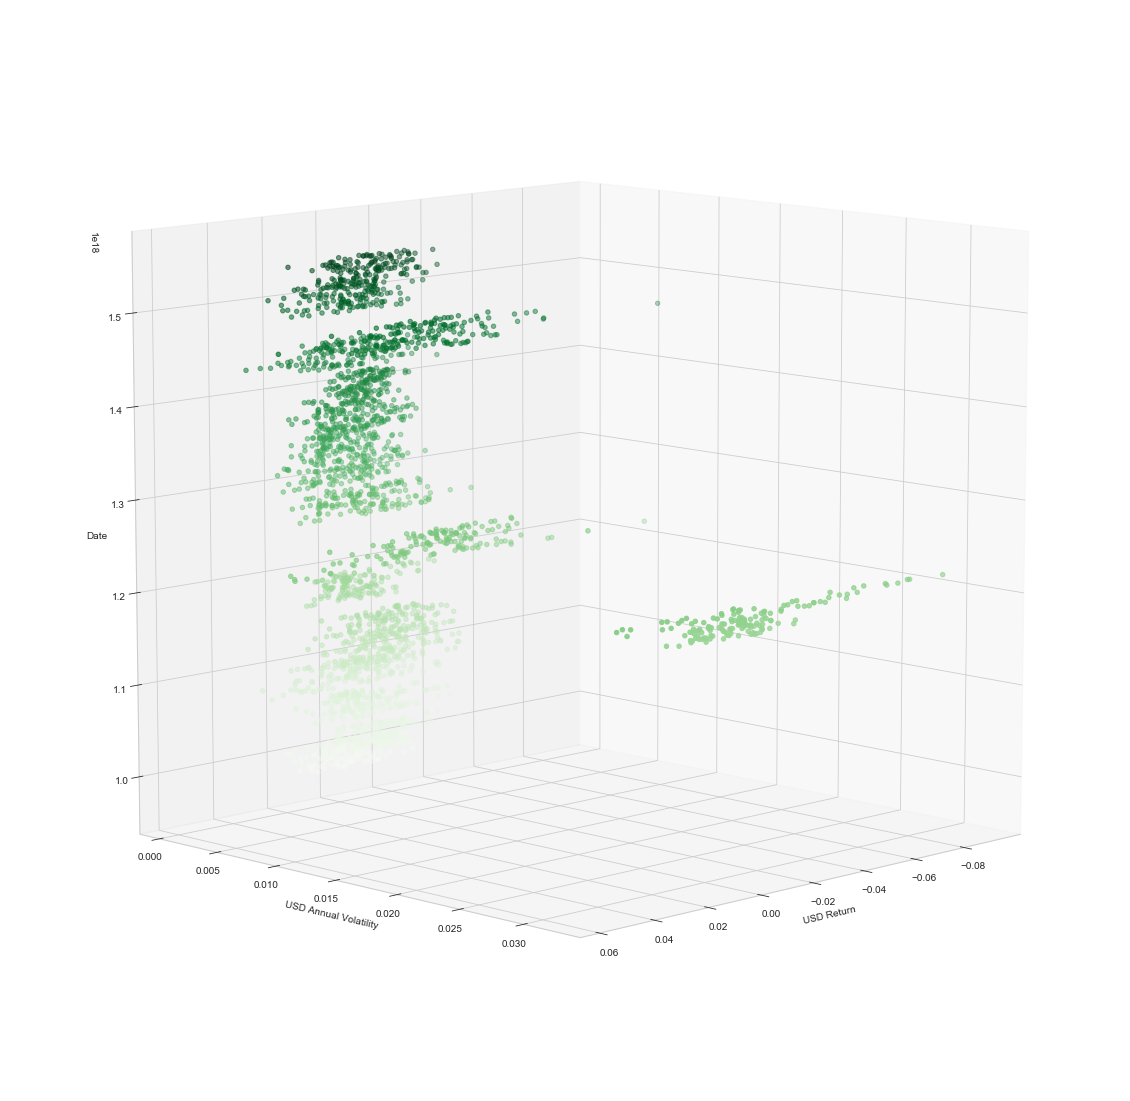

In [614]:
from mpl_toolkits import mplot3d
# gold prices

# test_df.index
# test_df.columns
# test_df[['1w_return_US /Dollar', '1y_vol_US Dollar']]

fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
ax.view_init(10, 45)

# Data for a three-dimensional line
# zline = test_df.index
# xline = test_df['1w_return_US Dollar']
# yline = test_df['1y_vol_US Dollar']**2
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = test_df.index
xdata = test_df['1w_return_US Dollar']
ydata = test_df['1y_vol_US Dollar']**2

ax.set_xlabel('USD Return')
ax.set_ylabel('USD Annual Volatility')
ax.set_zlabel('Date')

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [620]:
test_df
X = test_df[['1y_vol_US Dollar', '1y_vol_Japanese Yen']]
y_currency = 'US Dollar'
y_value = '1w_return'
y_string = y_value + '_' + y_currency
y = test_df[y_string]
y
X

,1y_vol_US Dollar,1y_vol_Japanese Yen
date,,
2001-01-03,0.024050,3.987248
2001-01-04,0.024050,3.987248
2001-01-05,0.024050,3.987248
2001-01-10,0.024050,3.987248
2001-01-11,0.024050,3.987248
2001-01-12,0.024050,3.987248
2001-01-17,0.024050,3.987248
2001-01-18,0.024050,3.987248
2001-01-19,0.024050,3.987248


In [621]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=1000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 2

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    print(degree, RMSE, test_score)

2 0.36644748710076686 -0.0006591174939776234
